# Helmholtz 1D - AutoAMG on a Fixed Domain Size - Multilevel

## Goal
Given the Helhmholtz operator $A = \Delta + k^2 I$ on a fixed domain with periodic boundary conditions, find **test functions** $x$ of unit $l_2$ norm with small $\|A x\|$; i.e., near-null-space components, and a multilevel hierarchy that is able to solve $A u = f$ fast.

In general, $k=k(x)$ varies over the domain. In thesse experiments, $k$ is constant, but we do not assume this knowledge.

## Discretization
We use the 5-point finite difference $A^h = [-1, 16, -30 + 12 (kh)^2, 16, -1]$. In this experiment we use a fixed periodic domain with $n=96$ points and a small $kh=0.5$.

In [23]:
import logging
import numpy as np
import helmholtz as hm
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm
from scipy.sparse.linalg import eigs

import helmholtz as hm
import helmholtz.setup.hierarchy as hierarchy

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Finest-level Eigenvalues

Smallest-magnitude eigenvalue -0.02393225657483029


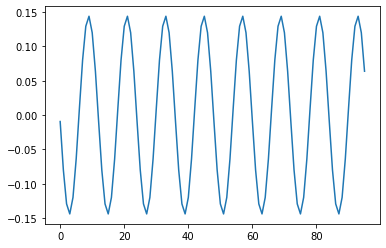

In [50]:
n = 96
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

lam, v = eig(a.todense())
lam = np.real(lam)
ind = np.argsort(np.abs(lam))
lam = lam[ind]
v = v[:, ind]
print("Smallest-magnitude eigenvalue", lam[0])
plt.plot(v[:, 0]);

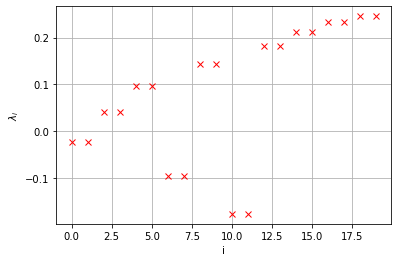

In [25]:
plt.plot(lam[:20], "rx")
plt.grid(True)
plt.xlabel("i")
plt.ylabel(r"$\lambda_i$");

## Two-level Bootstrap
We perform 4 bootstrap cycles, starting from 20 random test functions.
* R is constructed by SVD.
<!-- * P is contructed by regularized LS. -->
* P = R^T.
We measure the Residual to Error Ratio (RER) of test functions the two-level cycle convergence factor for $A x = 0$ (solving exactly at the coarse level), with $\nu_1+\nu_2=4$ relaxations per cycle 

In [26]:
# Fixed seed for reproducible results.
np.random.seed(0)

num_examples = 20
max_levels = 2
num_bootstrap_steps = 3
threshold = 0.1
interpolation_method = "svd" # "ls"
num_sweeps = 10

In [27]:
# # Initialize test functions (to random) and hierarchy at coarsest level.
# level = hierarchy.create_finest_level(a)
# multilevel = hm.hierarchy.multilevel.Multilevel(level)

# x, multilevel = hm.setup.auto_setup.setup(a, max_levels=3, num_bootstrap_steps=num_bootstrap_steps, num_examples=20,
#                               interpolation_method="svd", threshold=0.1)

## Level 0->1: Two-level Coarsening + Bootstrapping

In [28]:
_LOGGER = logger
x_log = {}

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
level = hierarchy.create_finest_level(a)
multilevel = hm.hierarchy.multilevel.Multilevel(level)
# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log[1] = []
x_log[1].append(x)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros_like(x)
x, conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x,num_sweeps=num_sweeps)
_LOGGER.info("Relax convergence factor {:.3f}".format(conv_factor))
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log[1].append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("-" * 80)
_LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
x_log[num_levels] = [x]
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    x, multilevel = hm.setup.auto_setup.bootstap(x, multilevel, num_levels, num_sweeps=num_sweeps,
                             interpolation_method=interpolation_method, threshold=threshold)
    x_log[num_levels].append(x)
    _LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x2 = x

INFO     Relax at level 0 size 96
INFO     Relax convergence factor 0.875
INFO     RER 0.318
INFO     --------------------------------------------------------------------------------
INFO     bootstrap with 96 levels
INFO     Bootstrap step 1/3
INFO     Relax cycle conv factor 0.994
INFO     Coarsening level 0->1
INFO     Aggregate sizes [4 4 4 4 4 4 4 4 4 4 4 4 4 8 4 4 8 4 8 8]
INFO     Mock cycle conv factor [0.607 0.379 0.247 0.206 0.157]
INFO     Level 1 size 47
INFO     RER 0.163
INFO     Bootstrap step 2/3
INFO     Relax cycle conv factor 0.834
INFO     Coarsening level 0->1
INFO     Aggregate sizes [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     Mock cycle conv factor [0.592 0.333 0.19  0.137 0.141]
INFO     Level 1 size 48
INFO     RER 0.086
INFO     Bootstrap step 3/3
INFO     Relax cycle conv factor 0.921
INFO     Coarsening level 0->1
INFO     Aggregate sizes [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     Mock cycle conv factor [0.586 0.332 0.199 0.135

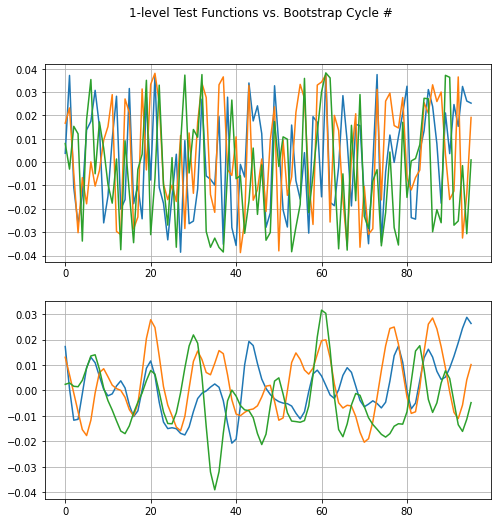

In [29]:
x_all = x_log[1]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('1-level Test Functions vs. Bootstrap Cycle #')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

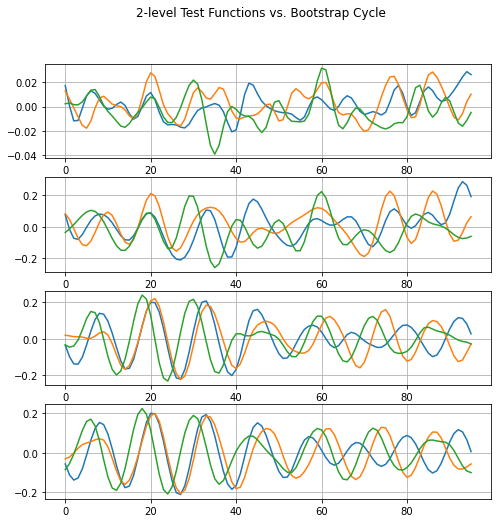

In [30]:
x_all = x_log[2]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('2-level Test Functions vs. Bootstrap Cycle')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

In [31]:
# # Bootstrap 3 levels.
# x = x2
# num_levels = 3
# _LOGGER.info("-" * 80)
# _LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
# x_log[num_levels] = [x]
# for i in range(num_bootstrap_steps):
#     _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
#     x, multilevel = hm.setup.auto_setup.bootstap(x, multilevel, num_levels, num_sweeps=num_sweeps,
#                              interpolation_method=interpolation_method, threshold=threshold)
#     x_log[num_levels].append(x)
#     _LOGGER.info("RER {:.2f}".format(norm(a.dot(x)) / norm(x)))

In [32]:
# x_all = x_log[3]
# fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
# fig.suptitle('2-level Test Functions vs. Bootstrap Cycle')
# for i, x in enumerate(x_all):
#     ax = axs[i]
#     for j in range(5):
#         ax.plot(x[:, j])
#     ax.grid(True);

## Level 1->2: Two-level Coarsening + Bootstrapping

In [33]:
level = multilevel.level[1]
a1 = level.a
x1 = level.coarsen(x2)

x1_improved, multilevel1 = hm.setup.auto_setup.setup(a1, max_levels=2, 
                                                     num_bootstrap_steps=5,
                                                     num_sweeps=30, print_frequency=3,
                                                     num_examples=num_examples, 
                                                     interpolation_method=interpolation_method, 
                                                     threshold=threshold, x=x1)

INFO     Relax at level 0 size 48
INFO     Relax convergence factor 0.997
INFO     RER 0.057
INFO     --------------------------------------------------------------------------------
INFO     bootstrap at grid size 48 with 2 levels
INFO     Bootstrap step 1/5
INFO         0 |r| 4.24960476e+00 RER 1.03477
INFO         3 |r| 1.28783091e-01 (0.85720) RER 0.12878 (0.85720) 1.00000
INFO         6 |r| 9.01697588e-02 (0.90307) RER 0.09017 (0.90307) 1.00000
INFO         9 |r| 7.18249833e-02 (0.93733) RER 0.07182 (0.93733) 1.00000
INFO        12 |r| 6.19982486e-02 (0.95834) RER 0.06200 (0.95834) 1.00000
INFO        15 |r| 5.60680406e-02 (0.97070) RER 0.05607 (0.97070) 1.00000
INFO        18 |r| 5.21386987e-02 (0.97840) RER 0.05214 (0.97840) 1.00000
INFO        21 |r| 4.93809293e-02 (0.98367) RER 0.04938 (0.98367) 1.00000
INFO        24 |r| 4.73782260e-02 (0.98747) RER 0.04738 (0.98747) 1.00000
INFO        27 |r| 4.58832381e-02 (0.99022) RER 0.04588 (0.99022) 1.00000
INFO        30 |r| 4.4733023

Even though the test function RER decreases, the two-level convergence factor is excellent after one bootstrap cycle, then gets worse and does not improve.

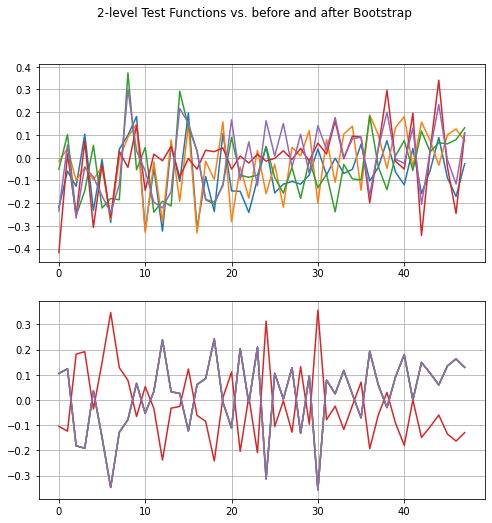

In [34]:
x_all = [x1, x1_improved]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('2-level Test Functions vs. before and after Bootstrap')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(5):
        ax.plot(x[:, j])
    ax.grid(True);

In [35]:
# Append level 2 found by 1->2 coarsening into the hierarchy of level 0.
#multilevel.level.append(multilevel1.level[1])
multilevel.level.append(multilevel1.level[1])

## Relaxation Cycle Convergence Factor vs. #levels

In [68]:
# 1-level: 4 relaxations = 1 iteration so we can compare with a relaxation cycle.
level = multilevel.level[0]
b = np.zeros((level.size, ))

y_all = {}
for num_levels in range(1, len(multilevel.level) + 1):
    print("#levels", num_levels)
    if num_levels == 1:
        def relax_cycle(x):
            for i in range(4):
                x = level.relax(x, b)
            return x
    else:
        def relax_cycle(x):
            return hm.solve.relax_cycle.relax_cycle(multilevel, 1.0, 2, 2, 4, num_levels=num_levels).run(x)
    y, conv_factor = hm.solve.run.run_iterative_method(
        level.operator, relax_cycle, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
        500,  print_frequency=50)
    y_all[num_levels] = y
    print("Conv Factor {:.5f}".format(conv_factor))

#levels 1
INFO         0 |r| 2.79294856e+00 RER 2.79295
INFO        50 |r| 2.26007105e-02 (0.98663) RER 0.08350 (0.99244) 0.27068
INFO       100 |r| 1.38945790e-02 (0.99247) RER 0.06411 (0.99595) 0.21672
INFO       150 |r| 1.00565498e-02 (0.99440) RER 0.05370 (0.99685) 0.18726
INFO       200 |r| 7.85906021e-03 (0.99570) RER 0.04668 (0.99755) 0.16836
INFO       250 |r| 6.51574685e-03 (0.99676) RER 0.04206 (0.99826) 0.15493
INFO       300 |r| 5.65977206e-03 (0.99755) RER 0.03917 (0.99885) 0.14450
INFO       350 |r| 5.07953461e-03 (0.99807) RER 0.03740 (0.99926) 0.13581
INFO       400 |r| 4.65368151e-03 (0.99839) RER 0.03629 (0.99951) 0.12822
INFO       450 |r| 4.31575884e-03 (0.99857) RER 0.03555 (0.99965) 0.12140
INFO       500 |r| 4.03056975e-03 (0.99868) RER 0.03500 (0.99972) 0.11515
Conv Factor 0.99868
#levels 2
INFO         0 |r| 3.06210614e+00 RER 3.06211
INFO        50 |r| 4.75131846e-02 (0.99166) RER 0.04751 (0.99166) 1.00000
INFO       100 |r| 3.92080309e-02 (0.99768) RER 0.0392

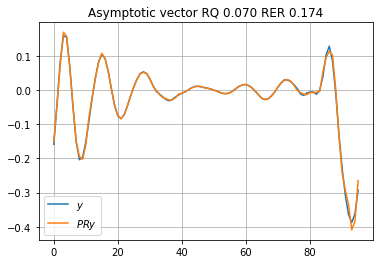

In [70]:
# Asymptotic vector of 3-level relaxation cycle is a smooth component.
coarse_level = multilevel.level[1]
p = coarse_level.p
r = coarse_level.r
y = y_all[3].flatten()
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
plt.plot(y, label="$y$")
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);

### Level 1->2 Relaxation Cycle

In [71]:
# 1-level: 4 relaxations = 1 iteration so we can compare with a relaxation cycle.
l = 1
level = multilevel.level[l]
b = np.zeros((level.size, ))
ml = hm.hierarchy.multilevel.Multilevel(level)
ml.level = multilevel.level[l:]

y_all = {}
for num_levels in range(1, len(ml.level) + 1):
    print("#levels", num_levels)
    if num_levels == 1:
        def relax_cycle(x):
            for i in range(4):
                x = level.relax(x, b)
            return x
    else:
        def relax_cycle(x):
            return hm.solve.relax_cycle.relax_cycle(ml, 1.0, 2, 2, 4, num_levels=num_levels).run(x)
    y, conv_factor = hm.solve.run.run_iterative_method(
        level.operator, relax_cycle, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
        500,  print_frequency=50)
    y_all[num_levels] = y
    print("Conv Factor {:.5f}".format(conv_factor))

#levels 1
INFO         0 |r| 1.24620745e+00 RER 1.24621
INFO        50 |r| 1.07449415e-02 (0.99104) RER 0.04475 (0.99570) 0.24010
INFO       100 |r| 8.10230419e-03 (0.99539) RER 0.04142 (0.99921) 0.19564
INFO       150 |r| 6.53099547e-03 (0.99595) RER 0.04021 (0.99959) 0.16241
INFO       200 |r| 5.37923531e-03 (0.99626) RER 0.03966 (0.99983) 0.13564
INFO       250 |r| 4.47843564e-03 (0.99640) RER 0.03945 (0.99994) 0.11351
INFO       300 |r| 3.74468522e-03 (0.99645) RER 0.03939 (0.99999) 0.09506
INFO       350 |r| 3.13575284e-03 (0.99646) RER 0.03939 (1.00000) 0.07960
INFO       400 |r| 2.62678845e-03 (0.99646) RER 0.03941 (1.00001) 0.06666
INFO       450 |r| 2.20042383e-03 (0.99646) RER 0.03942 (1.00001) 0.05582
INFO       500 |r| 1.84310662e-03 (0.99646) RER 0.03943 (1.00000) 0.04674
Conv Factor 0.99646
#levels 2
INFO         0 |r| 1.15086903e+00 RER 1.15087
INFO        50 |r| 2.06607716e-01 (1.00021) RER 0.20661 (1.00021) 1.00000
INFO       100 |r| 2.07452970e-01 (1.00001) RER 0.2074

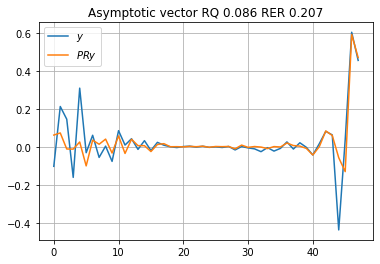

In [73]:
# Asymptotic vector of 2-level relaxation cycle at level 1 is still smooth.
coarse_level = ml.level[1]
p = coarse_level.p
r = coarse_level.r
y = y_all[2].flatten()
plt.plot(y, label="$y$")
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);

### Fine vs. Coarse Operator Eigenvalues

In [74]:
lam = [None] * len(multilevel)
v = [None] * len(multilevel)
for l in range(len(multilevel)):
    level = multilevel.level[l]
    lam[l], v[l] = eig(level.a.todense(), b=level.b.todense())
    lam[l] = np.real(lam[l])
    ind = np.argsort(np.abs(lam[l]))
    lam[l] = lam[l][ind]
    v[l] = v[l][:, ind]

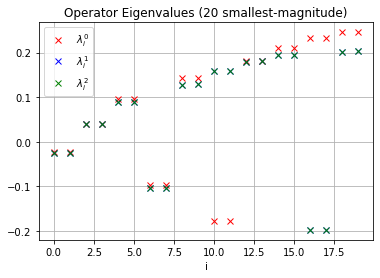

In [75]:
k = 20
lf = lam[0][:k][:, None] 
lc = lam[1][:k][:, None]
l2 = lam[2][:k][:, None]

plt.plot(lf, 'rx', label="$\lambda_i^0$")
plt.plot(lc, 'bx', label="$\lambda_i^1$")
plt.plot(lc, 'gx', label="$\lambda_i^2$")
plt.xlabel("i")
plt.grid(True)
plt.title("Operator Eigenvalues ({} smallest-magnitude)".format(k));
plt.legend();
#plt.xlim([-0.3, 0.3]);
#plt.ylim([-0.1, 0.1]);

In [76]:
pd.DataFrame(np.concatenate((lf, lc, l2,
                             np.abs(lc - lf)/np.abs(lf), np.abs(l2 - lf)/np.abs(lf),
                            ),  axis=1),
            columns=("lam0", "lam1", "lam2", "rel error 1", "rel error 2"))

,lam0,lam1,lam2,rel error 1,rel error 2
0,-0.023932,-0.024471,0.000322,0.022508,1.013435
1,-0.023932,-0.024510,0.011777,0.024148,1.492096
2,0.040200,0.038818,-0.028501,0.034380,1.708965
3,0.040200,0.039147,0.033101,0.026204,0.176595
4,0.095828,0.089195,0.044266,0.069215,0.538065
5,0.095828,0.089365,0.071623,0.067437,0.252589
6,-0.096528,-0.102860,0.093031,0.065593,1.963770
7,-0.096528,-0.103282,-0.189146,0.069966,0.959487
8,0.142921,0.128248,-0.211787,0.102669,2.481845
9,0.142921,0.128496,-0.219085,0.100934,2.532906


Eigenvalue -0.023932256574829756 -0.024470927030489788 -0.02850069724117531


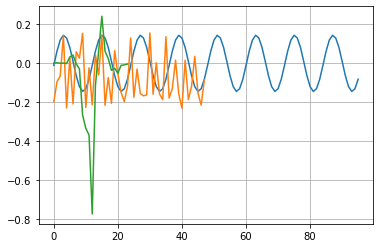

In [78]:
# Lowesst eigenfunction at levels 0..2.
plt.plot(v[0][:, 0])
plt.plot(v[1][:, 0])
plt.plot(v[2][:, 2])
plt.grid(True);
print("Eigenvalue", lam[0][0], lam[1][0], lam[2][2])

## Observations
#### 2-level
* We get a good result: mock cycle rates are good and improve with #relaxation sweeps (0.53, 0.33, 0.2, ...).
* The test function RER decreases with bootstrap cycles.
* The two-level relaxation cycle is able to reduce the residual faster than 1-level relaxation.

#### 3-level
* The mock cycle rates are much larger, but still improve with the number of relaxation sweeps, indicating that Kaczmarz is a less effective smoother for the level 1 equations than level 0 (~0.85, 0.81, 0.79, ...) and that we need more relaxations at level 1 during a cycle.
* The test function RER oscillates with bootstrap cycles.
* The 3-level relaxation cycle RER does not converge to the smallest eigenvalue. This indicates that there is a error component that is not reduced at all.

#### Questions
* We have a good quality metric of test functions (RER). We have a good metric of a coarsening operator (mock cycle). What is a good qualiy metric of a coarse level? Is it the convergence rate of a 2-level relaxation cycle? (converrgence needs to be measured towards the lowest eigenpair?).
* How can we find which points are not coarsened well? Can we tell by the asymptotically slowest vector of the relaxation cycle?